# Will it snow at the ESE 2024 Kongress?  

Copyright 2024 by [Doulos](https://www.doulos.com)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at:\
http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Part2- Preparing the Dataset 

Install in your virtual environment the requires Python packages (*polars* and *pandas*).\
Not needed if the packages are already installed.

In [1]:
# !pip install polars pandas matplotlib

load the raw data from the disk. 

In [2]:
import os
import polars as pl

path =  "dataset" # assume in dataset subfolder. change as needed
raw_data = pl.read_parquet(os.path.join(path,"stuttgart_dwd.parquet"))

In [3]:
print(f"""
shape  : {raw_data.shape}
columns: {raw_data.columns},
null   : {raw_data.null_count()}
""")


shape  : (701284, 6)
columns: ['station_id', 'dataset', 'parameter', 'date', 'value', 'quality'],
null   : shape: (1, 6)
┌────────────┬─────────┬───────────┬──────┬───────┬─────────┐
│ station_id ┆ dataset ┆ parameter ┆ date ┆ value ┆ quality │
│ ---        ┆ ---     ┆ ---       ┆ ---  ┆ ---   ┆ ---     │
│ u32        ┆ u32     ┆ u32       ┆ u32  ┆ u32   ┆ u32     │
╞════════════╪═════════╪═══════════╪══════╪═══════╪═════════╡
│ 0          ┆ 0       ┆ 0         ┆ 0    ┆ 69273 ┆ 69273   │
└────────────┴─────────┴───────────┴──────┴───────┴─────────┘



In [4]:
raw_data

station_id,dataset,parameter,date,value,quality
str,str,str,"datetime[μs, UTC]",f64,f64
"""04931""","""precipitation""","""precipitation_form""",2004-01-01 00:00:00 UTC,null,null
"""04931""","""precipitation""","""precipitation_form""",2004-01-01 01:00:00 UTC,0.0,1.0
"""04931""","""precipitation""","""precipitation_form""",2004-01-01 02:00:00 UTC,0.0,1.0
"""04931""","""precipitation""","""precipitation_form""",2004-01-01 03:00:00 UTC,null,null
"""04931""","""precipitation""","""precipitation_form""",2004-01-01 04:00:00 UTC,0.0,1.0
…,…,…,…,…,…
"""04931""","""temperature_air""","""temperature_air_mean_2m""",2023-12-31 20:00:00 UTC,5.6,3.0
"""04931""","""temperature_air""","""temperature_air_mean_2m""",2023-12-31 21:00:00 UTC,5.4,3.0
"""04931""","""temperature_air""","""temperature_air_mean_2m""",2023-12-31 22:00:00 UTC,5.1,3.0


### Inspect the Data structure 
- precipitation_form (value,quality) from t="2004-01-01 00:00 UTC" to t="2024-01-01 00:00 UTC"
- dito precipitation_height
- dito humidity
- dito temperature_air_mean

In [5]:
raw_data['parameter'].unique(maintain_order=True)

parameter
str
"""precipitation_form"""
"""precipitation_height"""
"""humidity"""
"""temperature_air_mean_2m"""


In [6]:
# usefull shorthand
PR_TYPE = "precipitation_form" 
PR_H = "precipitation_height"
TEMP = "temperature_air_mean_2m"
RH = "humidity"

### Data Wrangling 1: Reshaping as "Time Series"
It would be nicier to have a dataframe as follows
| date             | precipitation_form | precipitation_height | humidity           | temperature_air_mean_2m | 
|:----------------:|:------------------:|:--------------------:|:------------------:|:-----------------------:|
| 2004-01-01 00:00 | value at that date | value at that date   | value at that date | value at that date      |
| 2004-01-01 01:00 | value at that date | value at that date   | value at that date | value at that date      |
etc. 

This can be achieved using a **pivot table**

In [7]:
ts_data = raw_data.pivot(
        values="value",
        index="date",
        on="parameter",
        aggregate_function="first"
        )
ts_data

date,precipitation_form,precipitation_height,humidity,temperature_air_mean_2m
"datetime[μs, UTC]",f64,f64,f64,f64
2004-01-01 00:00:00 UTC,null,0.0,80.0,-1.1
2004-01-01 01:00:00 UTC,0.0,0.0,83.0,-1.3
2004-01-01 02:00:00 UTC,0.0,0.0,82.0,-1.1
2004-01-01 03:00:00 UTC,null,0.0,85.0,-1.4
2004-01-01 04:00:00 UTC,0.0,0.0,84.0,-1.4
…,…,…,…,…
2023-12-31 20:00:00 UTC,0.0,0.0,76.0,5.6
2023-12-31 21:00:00 UTC,0.0,0.0,76.0,5.4
2023-12-31 22:00:00 UTC,0.0,0.0,77.0,5.1


**Note**: We could have obtained this format directly by using the Settings options `ts_shape="wide"`. There are many ways to represent data, and the default format is not always the most effictive for analysis or interpreation. Polars (and Pandas) offer method to re-organize (and summarizes) the data, like pivot table.  

### Take a quick look at the data structure
We'll use describe to get basic statistic information. \
The stat info about the date and precipitation_form column are meaningless.

In [8]:
ts_data.describe()

statistic,date,precipitation_form,precipitation_height,humidity,temperature_air_mean_2m
str,str,f64,f64,f64,f64
"""count""","""175321""",109943.0,175231.0,173416.0,173421.0
"""null_count""","""0""",65378.0,90.0,1905.0,1900.0
"""mean""","""2013-12-31 12:00:00+00:00""",1.44494,0.075779,74.359096,10.239174
"""std""",null,2.645608,0.51311,17.224645,8.145396
"""min""","""2004-01-01 00:00:00+00:00""",0.0,0.0,13.0,-18.4
"""25%""","""2008-12-31 06:00:00+00:00""",0.0,0.0,63.0,4.0
"""50%""","""2013-12-31 12:00:00+00:00""",0.0,0.0,79.0,10.1
"""75%""","""2018-12-31 18:00:00+00:00""",0.0,0.0,88.0,16.1
"""max""","""2024-01-01 00:00:00+00:00""",9.0,48.9,100.0,36.7


<div class="alert alert-block alert-warning">
<b>Question:</b> <br>
Do you see any issue with one of the feature precipitation's height, humidity or temperature?
</div>

### Plot data distribution

In [9]:
import pandas as pd

df = ts_data.to_pandas()

array([[<Axes: title={'center': 'precipitation_form'}>,
        <Axes: title={'center': 'precipitation_height'}>],
       [<Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'temperature_air_mean_2m'}>]],
      dtype=object)

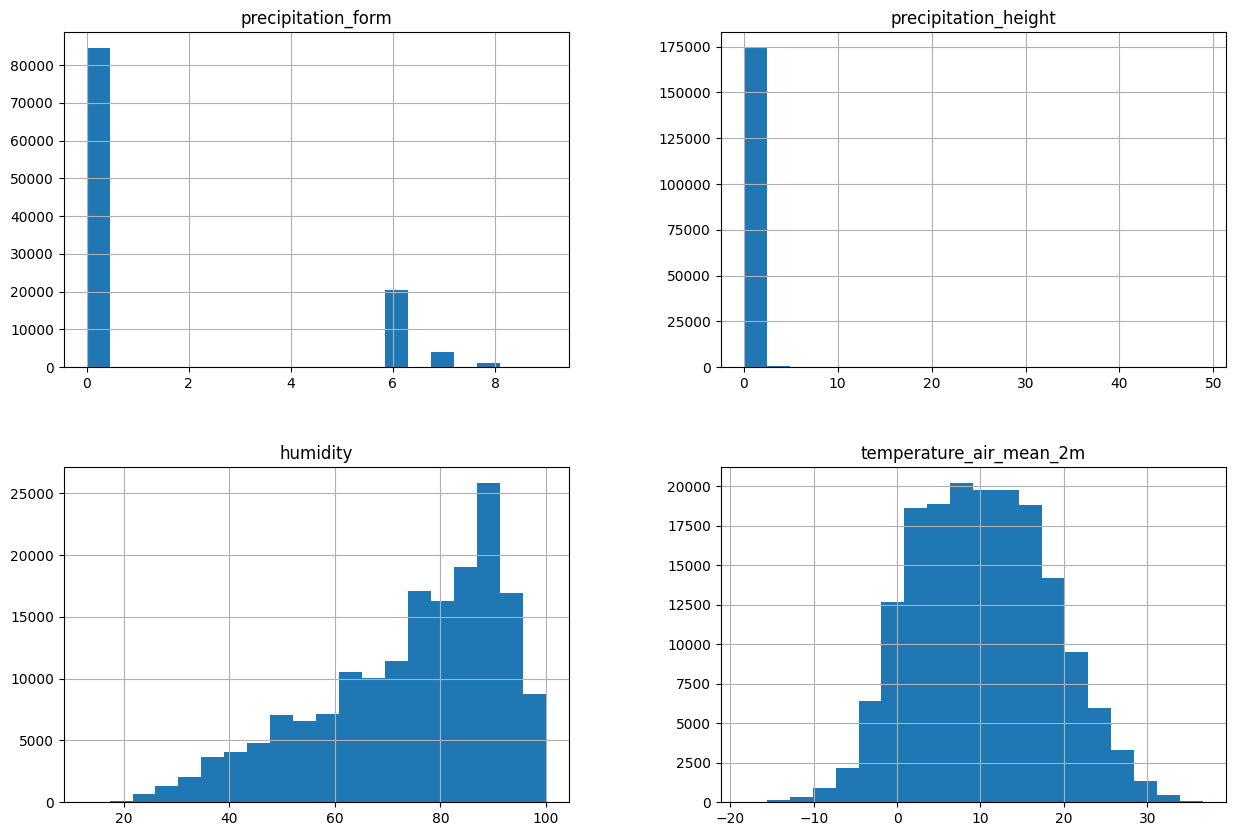

In [10]:
df.hist(column=[PR_TYPE, PR_H, RH, TEMP],bins=20,figsize=(15, 10))

#### Investigate Outliers

Precipitation height has apprently some outliers (max is 48.9). \
Is this outlier valid or not? 

In [11]:
max_height_index = ts_data['precipitation_height'].arg_max()
ts_data.slice(max_height_index-3,7)

date,precipitation_form,precipitation_height,humidity,temperature_air_mean_2m
"datetime[μs, UTC]",f64,f64,f64,f64
2021-06-28 16:00:00 UTC,0.0,0.0,55.0,26.7
2021-06-28 17:00:00 UTC,0.0,0.0,56.0,25.3
2021-06-28 18:00:00 UTC,null,0.0,65.0,24.1
2021-06-28 19:00:00 UTC,8.0,48.9,89.0,17.5
2021-06-28 20:00:00 UTC,6.0,6.4,96.0,17.0
2021-06-28 21:00:00 UTC,null,3.0,91.0,17.0
2021-06-28 22:00:00 UTC,6.0,0.6,94.0,16.9


<div class="alert alert-block alert-warning">
<b>Question:</b> <br>
Can you guess what kind of weather condition this outlier is? <br>
Hint: precipitation_form of type 8 means "mixed liquid/solid precipitation".
</div>

### Data Wrangling 2: Handling missing value (null)

#### Question? 
Do we have missing data? Yes- We know it already!

In [12]:
ts_data.null_count()

date,precipitation_form,precipitation_height,humidity,temperature_air_mean_2m
u32,u32,u32,u32,u32
0,65378,90,1905,1900


#### **Question?** How shall we handle the missing data?
There's no "one fit-all" answer. It will be depending of the problem treated. \
Some strategy: 
- drops any row with a null entry
- drops the null entry in some columns
- replace missing value by some numbers (0, mean, forward fill...)
- some conbinations of the 2 previous strategies

<div class="alert alert-block alert-warning">
<b>Question:</b> <br>
Why it's not a good idea to drop any row that has a null value?
</div>

Let's see if we can come up an imputation strategy: 
- Look at some entries where precipitation_form is null. How about precipitation_height?
- Look at some entries around a null value to get a feeling for what's going on. 

In [13]:
ts_data.filter( (pl.col("precipitation_form").is_null()) & (pl.col("precipitation_height")>1.0) )

date,precipitation_form,precipitation_height,humidity,temperature_air_mean_2m
"datetime[μs, UTC]",f64,f64,f64,f64
2004-01-06 21:00:00 UTC,null,1.1,85.0,3.0
2004-01-08 21:00:00 UTC,null,3.5,90.0,2.1
2004-01-10 00:00:00 UTC,null,3.0,91.0,1.6
2004-01-11 18:00:00 UTC,null,2.4,81.0,10.0
2004-01-11 21:00:00 UTC,null,5.1,87.0,6.0
…,…,…,…,…
2023-08-30 13:00:00 UTC,null,2.1,null,null
2023-08-30 23:00:00 UTC,null,2.0,null,null
2023-09-01 07:00:00 UTC,null,4.6,null,null


In [14]:
from datetime import datetime, timezone
sample = ts_data.filter(
    pl.col("date").is_between(datetime(2004, 1, 11,16, tzinfo=timezone.utc),datetime(2004,1,12,1, tzinfo=timezone.utc))
)
print(sample)

shape: (10, 5)
┌──────────────────────┬────────────────────┬──────────────────────┬──────────┬──────────────────────┐
│ date                 ┆ precipitation_form ┆ precipitation_height ┆ humidity ┆ temperature_air_mean │
│ ---                  ┆ ---                ┆ ---                  ┆ ---      ┆ _2m                  │
│ datetime[μs, UTC]    ┆ f64                ┆ f64                  ┆ f64      ┆ ---                  │
│                      ┆                    ┆                      ┆          ┆ f64                  │
╞══════════════════════╪════════════════════╪══════════════════════╪══════════╪══════════════════════╡
│ 2004-01-11 16:00:00  ┆ 6.0                ┆ 2.2                  ┆ 89.0     ┆ 9.8                  │
│ UTC                  ┆                    ┆                      ┆          ┆                      │
│ 2004-01-11 17:00:00  ┆ 6.0                ┆ 1.5                  ┆ 91.0     ┆ 9.3                  │
│ UTC                  ┆                    ┆             

We shall use a combined forward fill / backward fill
- if forward fill value is non zero => use it
- otherwise used backward fill value

In [15]:
ts_nogap = ts_data.with_columns(
        pl.when(pl.col(PR_TYPE).fill_null(strategy="forward") == 0)
        .then(pl.col(PR_TYPE).backward_fill())
        .otherwise(pl.col(PR_TYPE).fill_null(strategy="forward"))
        .alias(PR_TYPE)
    )

In [16]:
sample = ts_nogap.filter(
    pl.col("date").is_between(datetime(2004, 1, 11,16, tzinfo=timezone.utc),datetime(2004,1,12,1, tzinfo=timezone.utc))
)
print(sample)

shape: (10, 5)
┌──────────────────────┬────────────────────┬──────────────────────┬──────────┬──────────────────────┐
│ date                 ┆ precipitation_form ┆ precipitation_height ┆ humidity ┆ temperature_air_mean │
│ ---                  ┆ ---                ┆ ---                  ┆ ---      ┆ _2m                  │
│ datetime[μs, UTC]    ┆ f64                ┆ f64                  ┆ f64      ┆ ---                  │
│                      ┆                    ┆                      ┆          ┆ f64                  │
╞══════════════════════╪════════════════════╪══════════════════════╪══════════╪══════════════════════╡
│ 2004-01-11 16:00:00  ┆ 6.0                ┆ 2.2                  ┆ 89.0     ┆ 9.8                  │
│ UTC                  ┆                    ┆                      ┆          ┆                      │
│ 2004-01-11 17:00:00  ┆ 6.0                ┆ 1.5                  ┆ 91.0     ┆ 9.3                  │
│ UTC                  ┆                    ┆             

In [17]:
print("Before droping row with null entries: ", ts_nogap.shape)
ts_nogap = ts_nogap.drop_nulls()
print("After: ", ts_nogap.shape)

Before droping row with null entries:  (175321, 5)
After:  (173333, 5)


#### **Question?** How is the distribution "before" and "after" handling missing value?
Is the transformation acceptable? \
Let's do a scatter plot temperature/humidity for sample with snow (precipitation type is 3 or 7)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_snow_scatterplot(data, name, subplot_nr, temp_unit="°C", rh_unit="%"):
    precipitation = data[PR_TYPE].to_pandas()
    t = data[TEMP].to_pandas()
    h = data[RH].to_pandas()
    is_snowing =   (precipitation==7) | (precipitation==3) # snow is 3 or 7
    t_snow = t[is_snowing].dropna()
    h_snow = h[is_snowing].dropna()
    ax = plt.subplot(subplot_nr)
    ax.set_facecolor('#FFFAFA')
    sc = plt.scatter(t_snow, h_snow, c='#89cff0', label="Snow")
    plt.grid(color = 'black', linestyle = ':', linewidth=0.5)
    plt.legend()
    plt.title(name)
    plt.xlabel(f"Temperature {temp_unit}")
    plt.ylabel(f"Humidity {rh_unit}")

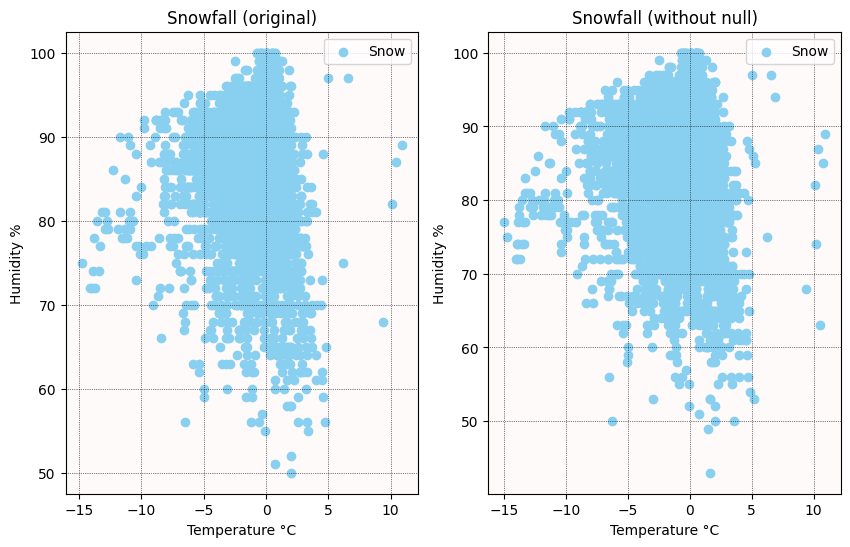

In [19]:
plt.figure(figsize=(10,6))
plot_snow_scatterplot(ts_data, "Snowfall (original)", 121)
plot_snow_scatterplot(ts_nogap, "Snowfall (without null)", 122)
plt.show()

### Input Feature Scaling using Z-score

In [20]:
t_mean = ts_nogap[TEMP].mean()
t_std  = ts_nogap[TEMP].std()
h_mean = ts_nogap[RH].mean()
h_std  = ts_nogap[RH].std()

In [21]:
print(f"""
{t_mean = }
{t_std  = }
{h_mean = }
{h_std  = }
""")


t_mean = 10.24183450352789
t_std  = 8.14499814071525
h_mean = 74.354998759613
h_std  = 17.225807868617938



In [22]:
dataset = ts_nogap.with_columns([
    (pl.col(TEMP)-t_mean)/t_std,
    (pl.col(RH)-h_mean)/h_std
    ])

In [23]:
ts_nogap.head(), dataset.head()

(shape: (5, 5)
 ┌──────────────────────┬────────────────────┬──────────────────────┬──────────┬──────────────────────┐
 │ date                 ┆ precipitation_form ┆ precipitation_height ┆ humidity ┆ temperature_air_mean │
 │ ---                  ┆ ---                ┆ ---                  ┆ ---      ┆ _2m                  │
 │ datetime[μs, UTC]    ┆ f64                ┆ f64                  ┆ f64      ┆ ---                  │
 │                      ┆                    ┆                      ┆          ┆ f64                  │
 ╞══════════════════════╪════════════════════╪══════════════════════╪══════════╪══════════════════════╡
 │ 2004-01-01 01:00:00  ┆ 0.0                ┆ 0.0                  ┆ 83.0     ┆ -1.3                 │
 │ UTC                  ┆                    ┆                      ┆          ┆                      │
 │ 2004-01-01 02:00:00  ┆ 0.0                ┆ 0.0                  ┆ 82.0     ┆ -1.1                 │
 │ UTC                  ┆                    ┆   

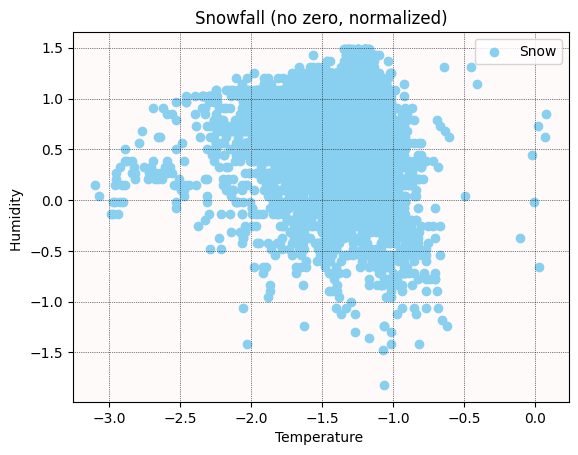

In [24]:
plot_snow_scatterplot(dataset, "Snowfall (no zero, normalized)", 111, temp_unit="", rh_unit="")

array([[<Axes: title={'center': 'temperature_air_mean_2m'}>,
        <Axes: title={'center': 'humidity'}>]], dtype=object)

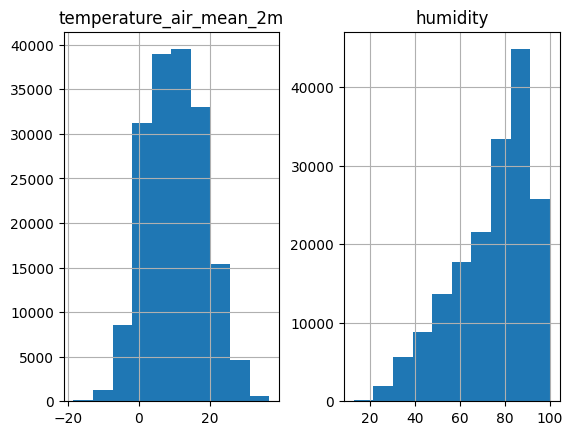

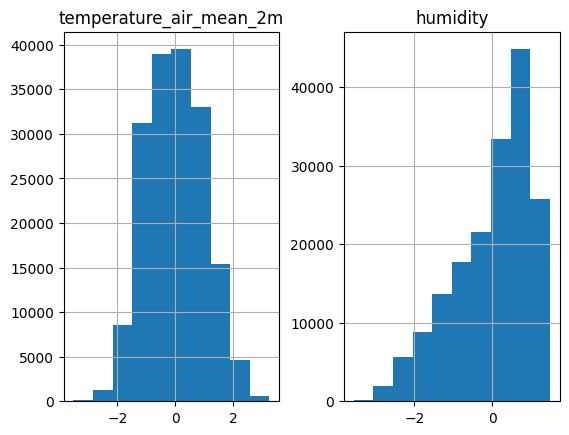

In [25]:
ts_nogap.to_pandas().hist(column=([TEMP,RH]))
dataset.to_pandas().hist(column=([TEMP,RH]))

## Save the dataset

This dataset can be used as a starting point for our machine learning. \
We must also save the values used for scaling parameters the temperature and humidity feature.

In [26]:
with open("feat_scaling.txt", "w") as f:
    print(t_mean, t_std, h_mean, h_std, end='\n', file=f)

dataset.write_parquet("dataset.parquet")